<img src="figuras/mbit-logo.png" align="right" style="float" width="200">
<font color="#CA3532"><h1 align="left">Clustering</h1></font>
<h2 align="left">Base de datos sintética. Mezclas de Gaussianas (EM)</h2>

Primero importamos las librerías que necesitaremos. También activaremos el modo *inline* para los gráficos generados por *matplotlib*. También inicializaremos la semilla del generador de números aleatorios.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as plt_colors
from matplotlib.patches import Ellipse
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn import mixture
from sklearn import metrics

Ahora crearemos un problema no supervisado sintético. El objetivo es entender los conceptos principales con este prolema, luego analizaremos bases de datos reales. Usaremos la función "make_blobs" que genera datos con un número especificado de "blobs". Esta función escoge aleatoriamente los centros de los blobs.

Los parámetros que cambiaremos se comentan aquí:

## Funciones para crear y dibujar los datos en el problema de los clusters elipsoidales

In [2]:
def rota_datos_alrededor_origen(X, angulo):
    angle_rad = angulo*2.0*np.pi/360.0

    s = np.sin(angle_rad)
    c = np.cos(angle_rad)
    matriz_rotacion = np.array([[c,-s],[s,c]])
    X_rotados = np.dot(matriz_rotacion, X) # se rotan los puntos generados

    return X_rotados

def genera_puntos_gaussiana2D(Npuntos, media, std1, std2, angulo):
    X = np.random.randn(2, Npuntos)
    X[0,:] = X[0,:] * std1 # se multiplica cada atributo por la
    X[1,:] = X[1,:] * std2 # desviación estándar deseada
    X = rota_datos_alrededor_origen(X, angulo)
    X[0,:] = media[0] + X[0,:]
    X[1,:] = media[1] + X[1,:]

    return X.T

def genera_puntos_disco2D(Npuntos, media, radio):
    radios  = radio*np.sqrt(np.random.rand(Npuntos))
    angulos = (2*np.pi)*np.random.rand(Npuntos)
    X = np.zeros((Npuntos,2))
    X[:,0] = media[0] + radios*np.cos(angulos)
    X[:,1] = media[1] + radios*np.sin(angulos)
    return X

def plot_ellipsoid(mean, cov, color, splot, alpha=0.5):
    v, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    ell = Ellipse(mean, v[0]*2, v[1]*2, 180 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(alpha)
    splot.add_artist(ell)
    splot.add_artist(Ellipse(mean, v[0]*2, v[1]*2, 180 + angle, color='black', fill=False))

def plot_ellipsoid_from_data(X, color, splot, alpha=0.5):
    plot_ellipsoid(np.mean(X.T, axis=1), np.cov(X.T), color, splot, alpha)

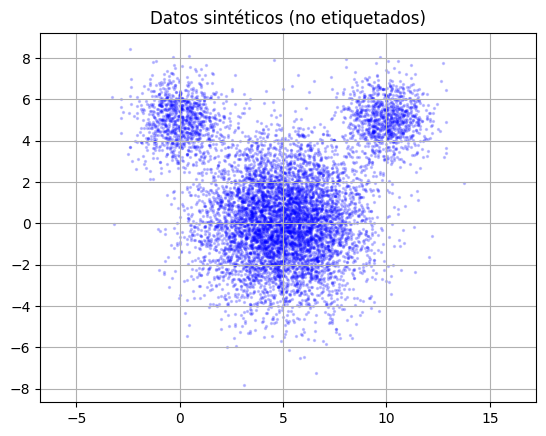

In [39]:
problema = 5

if problema==1:
    Nblobs = 3 # número de "blobs"
    X, y = make_blobs(random_state = 21,  # si cambiamos este parámetro cambiarán los "blobs" de ubicación
                      n_samples = 1000,   # número de puntos que serán generados en la base de datos
                      n_features = 2,     # número de dimensiones
                      centers = Nblobs,   # número de "blobs" (nubes)
                      cluster_std = 0.75) # ancho de cada "blob"

elif problema==2: # blobs de diferente tamanyo
    Nblobs = 3
    stds = [1, 3, 1]
    X, y = make_blobs(random_state = 21,  # si cambiamos este parámetro cambiarán los "blobs" de ubicación
                      n_samples = 1000,   # número de puntos que serán generados en la base de datos
                      n_features = 2,     # número de dimensiones
                      centers = Nblobs,   # número de "blobs" (nubes)
                      cluster_std = stds) # ancho de cada "blob"

elif problema==3: # dos "lunas" acopladas
    X = make_moons(n_samples=1000, noise=.1, random_state=21)[0]

elif problema==4: # circulo dentro de un circulo
    X = make_circles(n_samples=2000, factor=0.5, noise=.05, random_state=21)[0]

elif problema==5: # "Mickey Mouse"
    n_samples = 1000
    if False:
        X1 = genera_puntos_disco2D(n_samples, [0, 5], 2)
        X2 = genera_puntos_disco2D(n_samples, [10, 5], 2)
        X3 = genera_puntos_disco2D(int(5*5/2/2*n_samples), [5, 0], 5)
    else:
        X1 = genera_puntos_gaussiana2D(n_samples, [0, 5], 1, 1, 0)
        X2 = genera_puntos_gaussiana2D(n_samples, [10, 5], 1, 1, 0)
        X3 = genera_puntos_gaussiana2D(int(5*5/2/2*n_samples), [5, 0], 2, 2, 0)
    Xs = (X1, X2, X3)
    X = np.concatenate(Xs)

elif problema==6:
    n_samples = 1000
    #np.random.seed(0)
    X1 = genera_puntos_gaussiana2D(n_samples, [0, 0], 1, 1, 45)
    X2 = genera_puntos_gaussiana2D(n_samples, [10, 0], 3.5, 1, 45)
    X3 = genera_puntos_gaussiana2D(n_samples, [5, 5], 2, 1, 45)
    Xs = (X1, X2, X3)
    X = np.concatenate(Xs)
    colors = ['lightgreen', 'orange', 'yellow', 'magenta', 'lightblue']
    markers = ['s', 'v', 'o', 'd', 's']


    plt.figure(figsize=(6,6))
    splot = plt.subplot(1, 1, 1)
    for Xi,color in zip(Xs,colors):
        plot_ellipsoid_from_data(Xi, 'b', splot, alpha=0.2)

plt.scatter(X[:,0], X[:,1], color = 'b', s=2, alpha=0.2)
plt.grid()
plt.axis('equal')
plt.title('Datos sintéticos (no etiquetados)')
plt.show()

In [40]:
def colorea_puntos(u, cs):
    aux = np.zeros((len(u),3))
    nclusters = u.shape[1]
    for i in range(nclusters):
        a = plt_colors.cnames[cs[i]]
        c = [int(a[j:(j+2)],16) for j in range(1,7,2)]
#        print(c)
        for k in range(3):
            aux[:,k] = aux[:,k] + u[:,i]*c[k]
#    return aux.astype(np.int)
    aux = aux/255.
    return aux.clip(max=1.)

#colorea_puntos(np.array([[.5,0,.5],[0,1,0],[0,0,1]]), ['blue', 'red', 'green'])

In [41]:
Ncomponentes = 3    # número de componentes
#covariance_type='diag'
covariance_type='full'

gmm = mixture.GaussianMixture(n_components=Ncomponentes, covariance_type=covariance_type)
gmm.fit(X)

GaussianMixture(n_components=3)

In [45]:
centros = gmm.means_
covs    = gmm.covariances_
prioris = gmm.weights_

print(centros)
print()
print(covs)
print()
print(prioris)

[[ 9.97991416  5.03643884]
 [ 0.03705656  4.99535873]
 [ 4.98516859 -0.02888456]]

[[[ 1.02993975 -0.02129909]
  [-0.02129909  0.96216503]]

 [[ 1.07499928 -0.03790707]
  [-0.03790707  1.09041023]]

 [[ 3.89747002  0.02037162]
  [ 0.02037162  3.87802003]]]

[0.12146254 0.12366601 0.75487145]


In [46]:
u_tr = gmm.predict_proba(X)
u_tr

array([[8.00182308e-22, 9.97993934e-01, 2.00606570e-03],
       [5.72045645e-15, 9.86628341e-01, 1.33716591e-02],
       [1.06664999e-14, 6.86853590e-01, 3.13146410e-01],
       ...,
       [6.37275897e-13, 2.81604227e-20, 1.00000000e+00],
       [9.50494362e-16, 1.66658618e-04, 9.99833341e-01],
       [1.90316074e-12, 1.62013839e-11, 1.00000000e+00]])

In [47]:
gmm.predict(X)

array([1, 1, 1, ..., 2, 2, 2])

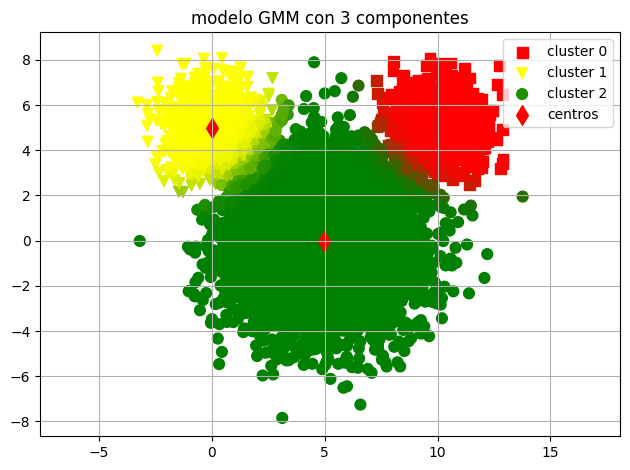

In [48]:
ax = plt.subplot(1,1,1)
colors = ['lightgreen', 'orange', 'yellow', 'magenta', 'lightblue']
colors = ['red', 'yellow', 'green', 'blue']
colors=10*colors

rgb_puntos = colorea_puntos(u_tr, colors)

markers = ['s', 'v', 'o', 'd', 's']
markers=10*markers
cluster_labels = u_tr.argmax(axis=1)
for i in range(Ncomponentes):
    aux = cluster_labels == i
    plt.scatter(X[aux, 0], X[aux, 1],
                s = 60, c = rgb_puntos[aux], marker = markers[i],
                label = 'cluster %d' % (i))

plt.scatter(centros[:,0], centros[:,1],
            s = 100, marker = 'd',
            c='red', label='centros')
plt.legend()
plt.grid()
plt.title(f'modelo GMM con {Ncomponentes} componentes')
plt.tight_layout()
plt.axis('equal')
plt.show()

In [49]:
covs

array([[[ 1.02993975, -0.02129909],
        [-0.02129909,  0.96216503]],

       [[ 1.07499928, -0.03790707],
        [-0.03790707,  1.09041023]],

       [[ 3.89747002,  0.02037162],
        [ 0.02037162,  3.87802003]]])

In [50]:
if covariance_type == 'diag':
    aux = np.zeros(covs.shape + (covs.shape[1],))
    for i in range(covs.shape[0]):
        aux[i] = np.diag(covs[i])
    covs = aux

<ipython-input-2-277b23567212>:34: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = Ellipse(mean, v[0]*2, v[1]*2, 180 + angle, color=color)
<ipython-input-2-277b23567212>:38: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  splot.add_artist(Ellipse(mean, v[0]*2, v[1]*2, 180 + angle, color='black', fill=False))


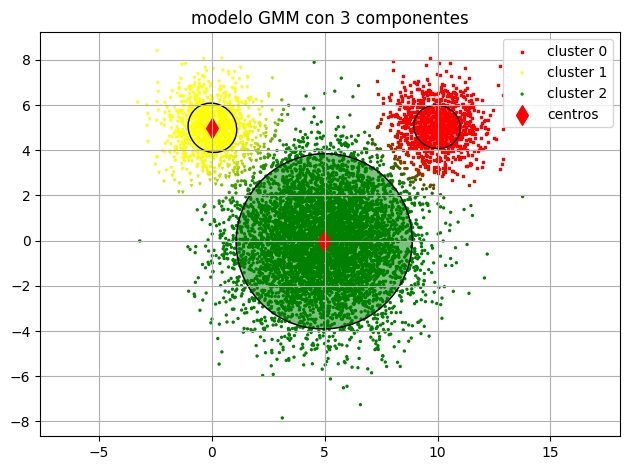

In [51]:
ax = plt.subplot(1,1,1)
for i in range(Ncomponentes):
    aux = cluster_labels == i
    plt.scatter(X[aux, 0], X[aux, 1],
                s = 2, c = rgb_puntos[aux], marker = markers[i],
                label = 'cluster %d' % (i))

for i in range(Ncomponentes):
    plot_ellipsoid(centros[i], covs[i], colors[i], ax, alpha=0.5)

plt.scatter(centros[:,0], centros[:,1], s = 100, marker = 'd',
            c='red', label='centros')

plt.legend()
plt.grid()
plt.title(f'modelo GMM con {Ncomponentes} componentes')
plt.tight_layout()
plt.axis('equal')
plt.show()
ejes = ax.axes.axis()

In [56]:
gmm.predict_proba([[5, 0]])

array([[4.03506115e-12, 1.45080802e-10, 1.00000000e+00]])

In [57]:
# log-likelihood del punto [5,0] (logaritmo de la densidad de probabilidad de ese punto)
gmm.score([[5, 0]])

-3.4770325320143

In [58]:
# densidad de probabilidad del punto [5,0]
np.exp(gmm.score([[5, 0]]))

0.03089896681595519

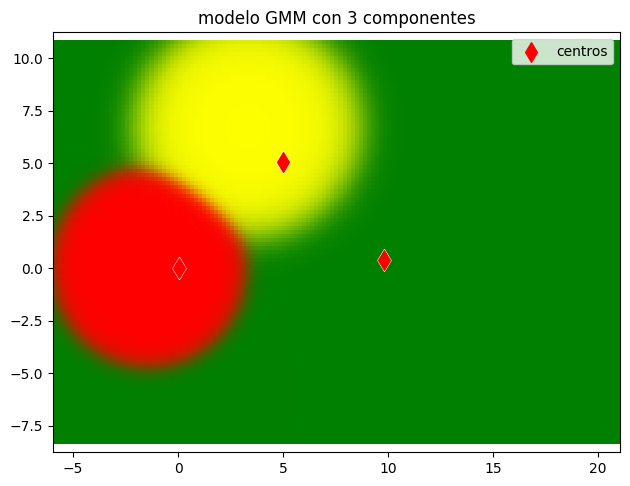

In [30]:
x_min, x_max, y_min, y_max = ejes
h = min([x_max-x_min, y_max-y_min])/100

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
a = np.c_[xx.ravel(), yy.ravel()]
u = gmm.predict_proba(a)

rgb_puntos = colorea_puntos(u, colors)
aux = rgb_puntos.reshape([xx.shape[0], xx.shape[1], 3])

plt.imshow(aux, origin='lower', extent=ejes, vmax=aux.max(), vmin=aux.min())
plt.scatter(centros[:,0], centros[:,1], s=120, marker='d', c='w')
plt.scatter(centros[:,0], centros[:,1], s=100, marker='d', c='r', label='centros')
plt.legend()
plt.title(f'modelo GMM con {Ncomponentes} componentes')
plt.tight_layout()
plt.axis('equal')
plt.show()

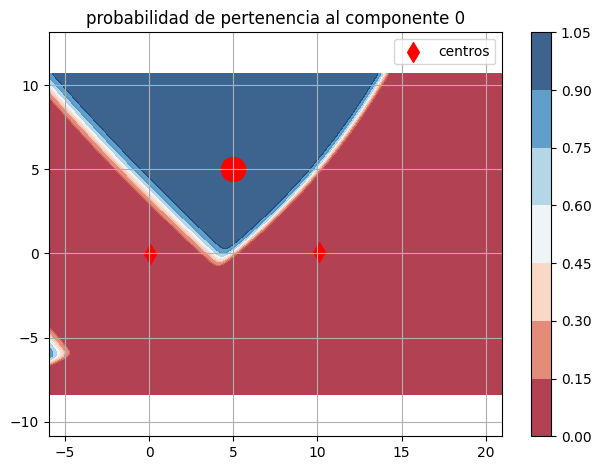

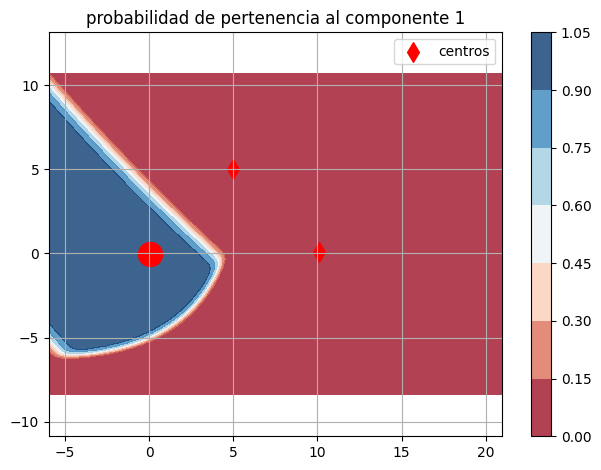

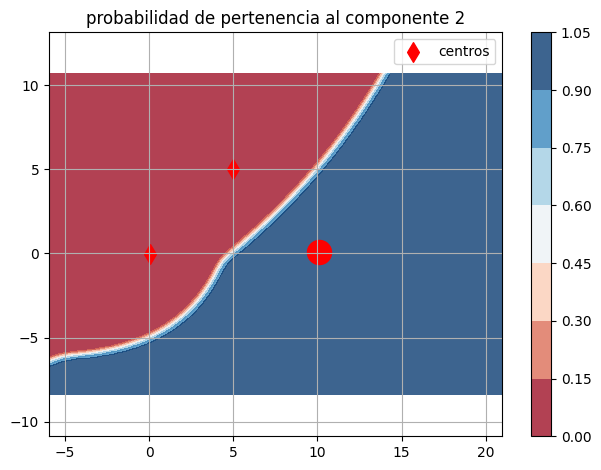

In [19]:
cm = plt.cm.RdBu
for c in range(Ncomponentes):
    ax = plt.subplot(1,1,1)
    uc = u[:,c]
    uc = uc.reshape(xx.shape)
    plt.contourf(xx, yy, uc, cmap=cm, alpha=.8, vmin=0, vmax=1)
    plt.colorbar()

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    plt.scatter(centros[:,0], centros[:,1],
            s = 100, marker = 'd',
            c='red', label='centros')
    plt.scatter(centros[c,0], centros[c,1], s=300, c='red')
    plt.legend()
    plt.title('probabilidad de pertenencia al componente '+str(c))
    plt.grid()
    plt.tight_layout()
    plt.axis('equal')
    plt.show()

Ahora interpretamos el clustering como crisp: consideramos que cada punto pertenece al cluster del cual tiene mayor grado de pertenencia

In [20]:
def soft2crisp(u):
    c = np.zeros(u.shape)
    for i in range(len(u)):
        c[i,u[i].argmax()] = 1
    return  c

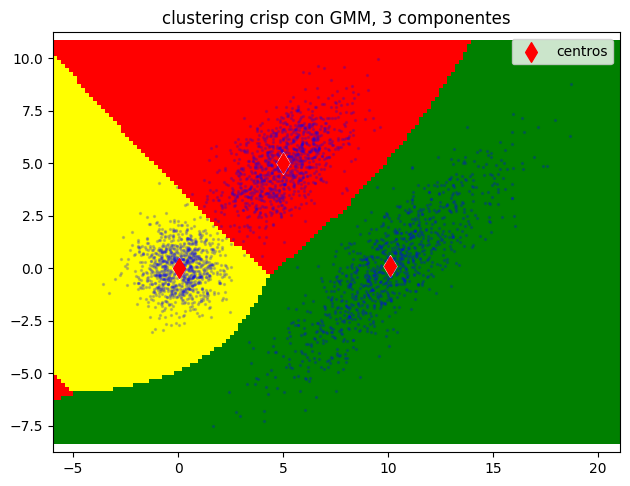

In [21]:
rgb_puntos = colorea_puntos(soft2crisp(u), colors)
aux = rgb_puntos.reshape([xx.shape[0], xx.shape[1], 3])

plt.imshow(aux, origin='lower', extent=ejes, vmax=aux.max(), vmin=aux.min())
plt.scatter(centros[:,0], centros[:,1],
            s = 120, marker = 'd',
            c='white')
plt.scatter(X[:,0], X[:,1], color = 'b', s=2, alpha=0.2)
plt.scatter(centros[:,0], centros[:,1],
            s = 100, marker = 'd',
            c='red', label='centros')
plt.legend()
plt.title(f'clustering crisp con GMM, {Ncomponentes} componentes')
plt.tight_layout()
plt.axis('equal');